# Convert a flight trajectory into a line on an image

This notebook shows how to take a single flight trajectory and find where in intersects with a photo.
This is effectively the reverse of the logic used in [Find FL Polygons](Find%20FL%20Polygons.ipynb).

## target image
First, let us pick a target image, and pull in the field-of-view and metadata associated with that image.

> 🖼️ target: `4xTdYYQZmj38MsRwWEH3`

In [1]:
import pickle
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import utm
import transformations as tf
import shapely
import geojson
import json
import simplekml
import matplotlib.pyplot as plt
import pymap3d
import tempfile
import datetime

from math import pi, sin, cos
from pycontrails.physics import geo, units
from magnetic_field_calculator import MagneticFieldCalculator
from PIL import Image, ExifTags
from google.cloud import bigquery, storage

GCS_BUCKET = "2024-06-contrails-workshop"
PHOTO_ID = "4xTdYYQZmj38MsRwWEH3"
PHOTO_BLOB = f"observerapp_hackathon/images/{PHOTO_ID}"

bq_client = bigquery.Client()
gcs_client = storage.Client()
gcs_bucket = gcs_client.get_bucket(GCS_BUCKET)

In general, we will need to have calibration data from the phone camera to properly interpret the image. We can peak at the metadata of this image to get some idea of camera used in this photo.

Premature end of JPEG file


EXIF data:
{'ImageWidth': 1920, 'ImageLength': 1920, 'ExifOffset': 138, 'Make': 'Google', 'Model': 'Pixel 6a', 'Orientation': 3, 'DateTime': '2024:02:28 15:03:30\x00', 'ExifVersion': b'0220', 'ExifImageWidth': 1920, 'DateTimeOriginal': '2024:02:28 15:03:30\x00', 'DateTimeDigitized': '2024:02:28 15:03:30\x00', 'ExifImageHeight': 1920, 'WhiteBalance': 0, 'Flash': 0, 'FocalLength': 4.38, 'OffsetTime': '-07:00', 'OffsetTimeOriginal': '-07:00', 'OffsetTimeDigitized': '-07:00', 'SubsecTime': '641826', 'SubsecTimeOriginal': '641826', 'SubsecTimeDigitized': '641826', 'ExposureTime': 0.000213795, 'FNumber': 1.73, 'ISOSpeedRatings': 57, 'MakerNote': b'\n\x02\x18\x01'}


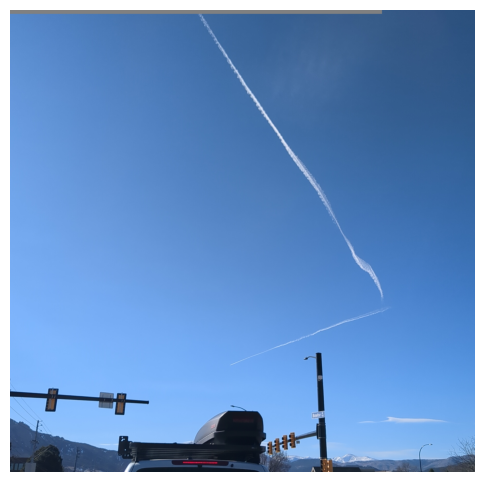

In [2]:
with tempfile.NamedTemporaryFile() as tmp:
    blob = gcs_bucket.blob(PHOTO_BLOB)
    blob.download_to_file(tmp)
    fig, ax = plt.subplots(1,figsize=(6,6))
    img_color = cv.imread(tmp.name)
    ax.imshow(img_color[...,::-1],aspect='auto')
    ax.set_axis_off()
    img = Image.open(tmp.name)
    exif = { ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS }
    print("EXIF data:")
    print(exif)

We can see from the `Model`, and `FocalLength` fields that this was taken on a wide-angle lens on a Pixel 6.  We happen to have a calibration matrix from a *different* Pixel 6. Note: the file `camera_calibration.p` is from the standard lens and `camera_wide.p` is the wide field-of-view lens (zoom 0.7x). Lets see what happens if we reuse this calibration.  We will shift the optical center of calibration to match the center of this photo, then undo the lens distortion, which in this photo is barely perceptable.

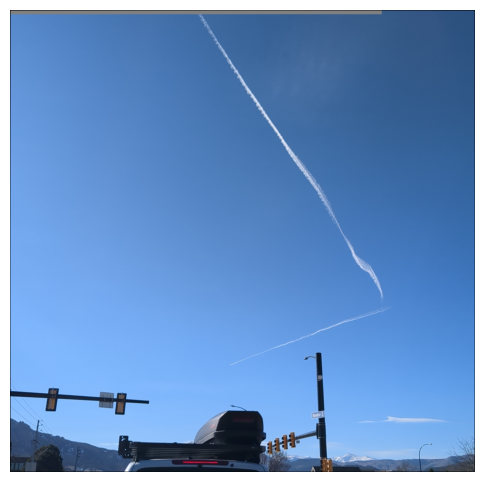

In [3]:
with open("camera_wide.p", "rb") as cal_infile:
    calibration = pickle.load(cal_infile)
    
# Force the optical center of the image to be the center of the camera matrix
ny, nx, _ = img_color.shape
calibration['cam_matrix'][0,2] = nx/2.0
calibration['cam_matrix'][1,2] = ny/2.0
fig, ax = plt.subplots(1,figsize=(6,6))
img_undistorted = cv.undistort(img_color,calibration['cam_matrix'],calibration['distortion_coeffs'])
ax.imshow(img_undistorted[...,::-1],aspect='auto')
ax.set_axis_off()

## Reconstruct the phone pose

In [4]:
# Get photo metadata from big query so we have sensor data and location
QUERY = (
    'SELECT timestamp, latitude, longitude, magnetometer, accelerometer, altitude, model FROM `contrails-301217.workshop_observerapp.image_metadata`'
    f'WHERE id = "{PHOTO_ID}"')
query_job = bq_client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
ra = list(rows)
assert len(ra) == 1
photo_info = ra[0]

In [5]:
acceleration = np.array([
    [photo_info.accelerometer[0]['x']], 
    [photo_info.accelerometer[0]['y']], 
    [photo_info.accelerometer[0]['z']]]
)
magnetometer = np.array([
    [photo_info.magnetometer[0]['x']], 
    [photo_info.magnetometer[0]['y']], 
    [photo_info.magnetometer[0]['z']]]
)
# at rest, observed acceleration is up
up__phone = acceleration / np.linalg.norm(acceleration)

# magnetic field points north (note that this differs from the physics convention)
H__phone = magnetometer / np.linalg.norm(magnetometer)

# Apple multiplies the accelerometer by g (-9.81) so we need to correct the signs
if 'iPhone' in photo_info.model:
    up__phone *= -1
    H__phone *= -1

In [6]:
location = {'latitude': photo_info.latitude, 'longitude': photo_info.longitude, 'altitude': photo_info.altitude}
location_utm = utm.from_latlon(location['latitude'], location['longitude'])

# Get magnetic declination for current location
mag_calc = MagneticFieldCalculator()
mag_data = mag_calc.calculate(
    latitude=-location['latitude'],
    longitude=location['longitude'],
    altitude=location['altitude'],
    date='2020-12-31' # This doesn't really matter as long as it's not a hundred years in the past or something
)

In [7]:
# construct east-north-up frame
mag_east__phone = np.cross(H__phone, up__phone, 0, 0, 0)
mag_east__phone = mag_east__phone / np.linalg.norm(mag_east__phone)
mag_north__phone = np.cross(up__phone, mag_east__phone, 0, 0, 0)
mag_north__phone = mag_north__phone / np.linalg.norm(mag_north__phone)

R__phone__mag_enu = np.hstack((mag_east__phone, mag_north__phone, up__phone))
R__mag_enu__phone = R__phone__mag_enu.T

declination = mag_data['field-value']['declination']['value'] * pi / 180 # sign of declination is reversed to make it a right-hand rotation around up

R__enu__mag_enu = np.array([[cos(declination), -sin(declination), 0],
                            [sin(declination),  cos(declination), 0],
                            [               0,                 0, 1]])

R__enu__phone = R__enu__mag_enu @ R__mag_enu__phone



phone_pose__enu = np.block([
    [R__enu__phone, np.array([[location_utm[0]], [location_utm[1]], [location['altitude']]])],
    [np.array([[0, 0, 0, 1]])]
])

# Android phone coordinate frame is defined here:
#    https://developer.android.com/guide/topics/sensors/sensors_overview#sensors-coords
# Looking at the screen, with the phone in portrait orientation:
#  - X is to the right
#  - Y is up
#  - Z is coming out of the screen

# Nominal rotation from camera frame (right-down-forward) to phone frame (right-up-backward)
# The true rotation is likely different. This is a source of error. An extrinsic calibration would be necessary to
# measure this error.
R__phone__cam = np.array([[ 1,  0,  0],
                          [ 0, -1,  0],
                          [ 0,  0, -1]])

# The camera pose is the transform from camera coords (right-down-forward) to world coords (east-north-up)
T__enu__cam = np.block([
    [R__enu__phone @ R__phone__cam, np.array([[location_utm[0]], [location_utm[1]], [location['altitude']]])],
    [np.array([[0, 0, 0, 1]])]
])

print("Camera principle axis (ENU):", T__enu__cam[:3, 2])

Camera principle axis (ENU): [-0.88051297  0.00940164  0.47392882]


## Sanity check the phone pose

We're going to manually look at where the code above thinks the camera is pointing but computing the effective bearing and zenith angle of each pixel of the phone

In [8]:
# Produce cartesean product of photo coordinates
x_px = nx
y_px = ny
x = np.arange(0,x_px) 
y = np.arange(0,y_px) 
pts__img = np.dstack(np.meshgrid(x, y)).reshape(-1, 2).astype('float')

# Apply undistortion - essentially a low-order polynomial correction to model lens flare
# Also add homogeneous coordiante
pts__undistorted_img = cv.undistortImagePoints(pts__img.T, calibration['cam_matrix'], calibration['distortion_coeffs'])[:,0,:]
pts__undistorted_img = np.hstack((pts__undistorted_img,np.ones((pts__undistorted_img.shape[0],1))))

# Back project using camera matrix - these are now rays pointing towards the camera principal point
rays__cam = np.linalg.inv(calibration['cam_matrix']) @ pts__undistorted_img.T

# Rotate from camera (up,right,forward) to world (east, north, up) and normalize so we have unit vectors
rays__enu = T__enu__cam[:3,:3] @ rays__cam
rays__enu /= np.linalg.norm(rays__enu,axis=0)

# unit vectors to get az/el
north = np.array([[0],[1],[0]])
up = np.array([[0],[0],[1]])

# "elevation" is degrees away from zenith
az = np.arccos(np.dot(north.T,rays__enu))
el = np.arccos(np.dot(up.T,rays__enu))

el_mask = (el < units.degrees_to_radians(80)).reshape((y_px,x_px))

Let's first look at the portion of the photo we think is above the horizon (well 10 degrees above the horizon). 

**You'll notice that it looks like this photo got rotated 90 degrees!**

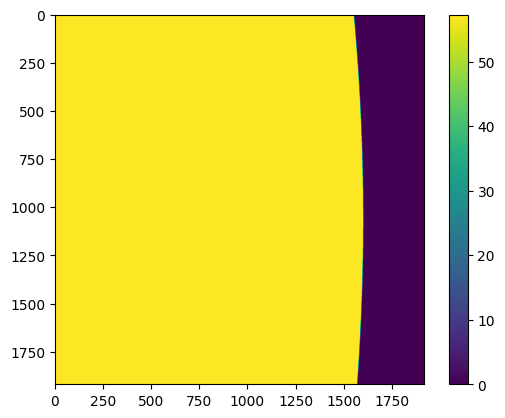

In [9]:
plt.imshow(units.radians_to_degrees(el_mask.reshape((y_px,x_px))))
plt.colorbar()

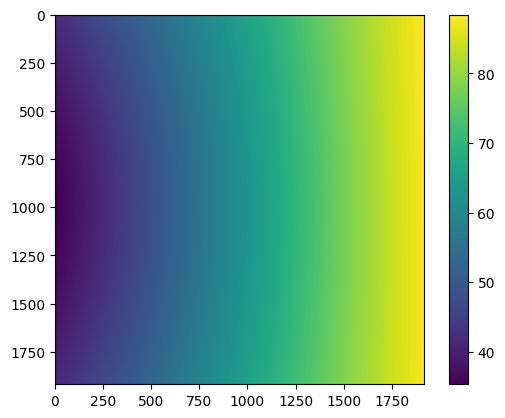

In [10]:
plt.imshow(units.radians_to_degrees(el.reshape((y_px,x_px))))
plt.colorbar()

Now take a look at the azimuth.  If you look at the code where we computed azimuth, we just took `arccos` and so we didn't actually compute whether the azimuth angle is positive or negative w.r.t. north unit vector. Here we are manually correcting it.

[Streetview pose](https://www.google.com/maps/@40.000114,-105.2321297,3a,77.9y,279.31h,124.84t/data=!3m7!1e1!3m5!1sCI67H-EPIZ-BIkIQFFDa9w!2e0!6shttps:%2F%2Fstreetviewpixels-pa.googleapis.com%2Fv1%2Fthumbnail%3Fpanoid%3DCI67H-EPIZ-BIkIQFFDa9w%26cb_client%3Dmaps_sv.share%26w%3D900%26h%3D600%26yaw%3D279.306885536236%26pitch%3D-34.8444823830353%26thumbfov%3D90!7i16384!8i8192?coh=205410&entry=ttu) for comparison. **We're pretty close!!** The photo is almost exactly due west. The map below is rotated 90 degrees just like the one above

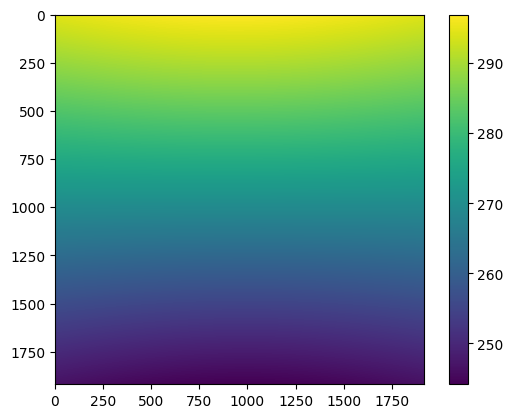

In [11]:
plt.imshow(360-units.radians_to_degrees(az.reshape((y_px,x_px))))
plt.colorbar()

## Pull a plane trajectory that intersects with the photo field of view
See [Nick's Demo](../contributions/masson_demo.ipynb) for how we found this plane

In [12]:
def rotate_pixels(arr, angle, nx, ny):
    assert arr.shape[1] == 2
    offset = np.zeros_like(arr)
    offset[:,0] = nx/2
    offset[:,1] = ny/2
    a_rad = units.degrees_to_radians(angle)
    rot_mtx = np.array([[np.cos(a_rad), -1*np.sin(a_rad)],[np.sin(a_rad), np.cos(a_rad)]])
    return ((arr - offset) @ rot_mtx) + offset

In [13]:
QUERY = (
    """SELECT *, ST_X(position) as longitude, ST_Y(position) as latitude
    FROM `contrails-301217.workshop_observerapp.adsb_clean_resampled` 
    WHERE timestamp BETWEEN DATETIME("2024-02-28 21:02:00") AND DATETIME_ADD("2024-02-28 21:02:00", INTERVAL 2 HOUR) 
    AND icao_address LIKE 'A44C70'
    ORDER BY timestamp"""
)
query_job = bq_client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
image_df = rows.to_dataframe()
display(image_df)

,timestamp,position,flight_level,altitude_baro,icao_address,tail_number,flight_number,aircraft_type_icao,airline_iata,longitude,latitude
0,2024-02-28 21:02:02,POINT(-115.034569 43.243958),220,21900.0,A44C70,N3760C,DL874,B738,DL,-115.034569,43.243958
1,2024-02-28 21:03:02,POINT(-114.865395 43.219143),230,23425.0,A44C70,N3760C,DL874,B738,DL,-114.865395,43.219143
2,2024-02-28 21:04:00,POINT(-114.697006 43.194332),250,24950.0,A44C70,N3760C,DL874,B738,DL,-114.697006,43.194332
3,2024-02-28 21:05:00,POINT(-114.521866 43.168121),260,26375.0,A44C70,N3760C,DL874,B738,DL,-114.521866,43.168121
4,2024-02-28 21:06:00,POINT(-114.340401 43.140747),270,27450.0,A44C70,N3760C,DL874,B738,DL,-114.340401,43.140747
...,...,...,...,...,...,...,...,...,...,...,...
111,2024-02-28 22:57:03,POINT(-96.315407 37.097153),350,35000.0,A44C70,N3760C,DL874,B738,DL,-96.315407,37.097153
112,2024-02-28 22:58:03,POINT(-96.159592 37.015732),350,35000.0,A44C70,N3760C,DL874,B738,DL,-96.159592,37.015732
113,2024-02-28 22:59:04,POINT(-96.003609 36.933613),350,35000.0,A44C70,N3760C,DL874,B738,DL,-96.003609,36.933613
114,2024-02-28 23:00:04,POINT(-95.851295 36.853359),350,35000.0,A44C70,N3760C,DL874,B738,DL,-95.851295,36.853359


Now do the conversion from world coordinates to the undistorted image space

In [14]:
# GPS to ENU coordinates
easting, northing, _, _ = utm.from_latlon(image_df['latitude'],image_df['longitude'],location_utm[2], location_utm[3])

# Tranform from world coordinates (east-north-up) to camera coordinates (right-down-forward)
T__cam__enu = np.linalg.inv(T__enu__cam)

# Camera matrix in projective coordinates
P = np.hstack((calibration['cam_matrix'], np.array([[0], [0], [0]])))

px = []
for i in range(len(easting)):
    plane__enu = np.array([[easting[i], northing[i], image_df['altitude_baro'][i], 1]]).T
    plane__cam = T__cam__enu @ plane__enu
    plane__cam /= plane__cam[-1]
    plane__undistorted_img = P @ plane__cam
    plane__undistorted_img /= plane__undistorted_img[-1]
    pt = plane__undistorted_img[0:2]
    
    #Only save trajectory points in FOV
    if np.all(pt > 0) and np.all(pt<ny):
        px.append(pt)
px = np.array(px)[:,:,0]

Just plotting each resampled ADSB point separately, we can see that the samples appear closer together near the horizon. They are resampled to a period of one minute so this is exactly what we'd expect.

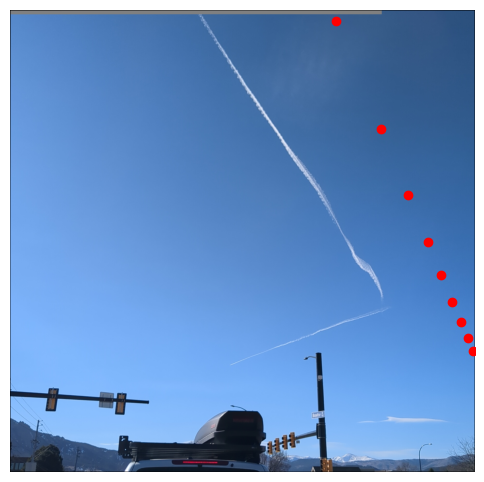

In [16]:
rot = rotate_pixels(px, -90, nx, ny)
fig, ax = plt.subplots(1,figsize=(6,6))
ax.imshow(img_undistorted[...,::-1],aspect='auto')
ax.scatter(rot[:,0],rot[:,1], c='red')
ax.set_axis_off()

### Add wind data
From the image above, it looks like this flight *could* be a match. Let's pull some met data to see which way the contrail should be advecting.

In [17]:
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.core import Flight

era5 = ERA5(
    time=("2024-02-28 21:00:00", "2024-02-29 00:00:00"),
    variables=["u", "v", "z"], 
    pressure_levels=[150, 200, 250, 300, 350, 400, 500],
)
met_pl = era5.open_metdataset()

In [18]:
# Create a pycontrails Flight object so we can easily interpolate the winds
image_df = image_df.rename(columns={'altitude_baro':'altitude_ft','timestamp':'time'})
fl = Flight(image_df)
fl['northward_wind'] = fl.intersect_met(met_pl['northward_wind'])
fl['eastward_wind'] = fl.intersect_met(met_pl['eastward_wind'])

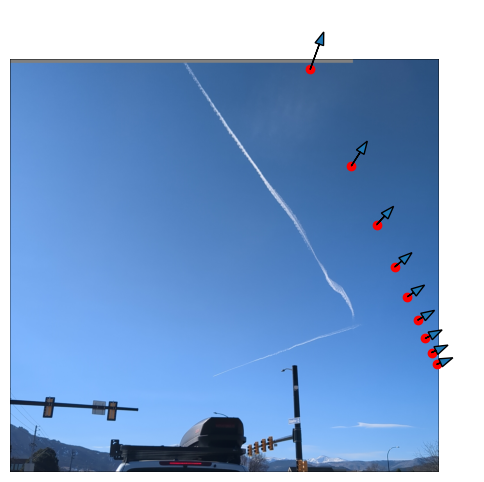

In [19]:
# Now follow the same logic to project a set of vectors on each waypoint facing the direction of the wind.

# Scale arrow size by this amount
scale = 100.0

# We need to start with the coordiantes of the plane, so it's just as easy to recompute everything from scratch
# than to use the existing pixel values
arrow_end = []
for i in range(len(easting)):
    # We need the projected locations of the waypoints as the base of the arrows
    plane__enu = np.array([[easting[i], northing[i], image_df['altitude_ft'][i], 1]]).T
    plane__cam = T__cam__enu @ plane__enu
    plane__cam /= plane__cam[-1]
    plane__undistorted_img = P @ plane__cam
    plane__undistorted_img /= plane__undistorted_img[-1]
    pt = plane__undistorted_img[0:2]
    
    #Only save trajectory points in FOV
    if np.all(pt > 0) and np.all(pt<ny):
        # Project wind vector onto image using same approach
        # Simply add the east and north components of the wind to the ENU coordinates of the waypoint
        arrow__enu = np.array([[
            easting[i]+scale*fl['eastward_wind'][i], 
            northing[i]+scale*fl['northward_wind'][i], 
            image_df['altitude_ft'][i], 
            1]]).T
        arrow__cam = T__cam__enu @ arrow__enu
        arrow__cam /= arrow__cam[-1]
        arrow__undistorted_img = P @ arrow__cam
        arrow__undistorted_img /= arrow__undistorted_img[-1]
        pt = arrow__undistorted_img[0:2]
        arrow_end.append(pt)
        
arrow_end = np.array(arrow_end)[:,:,0]

#Rotate everything back as we did before
rot_px = rotate_pixels(px, -90, nx, ny)
rot_arrow = rotate_pixels(arrow_end, -90, nx, ny)

fig, ax = plt.subplots(1,figsize=(6,6))
ax.imshow(img_undistorted[...,::-1],aspect='auto')
ax.scatter(rot_px[:,0],rot_px[:,1], c='red')
for i in range(len(rot_px)):
    # Syntax for plotting an arrow is (x origin, y origin, x length, y length)
    ax.arrow(
        rot_px[i,0],
        rot_px[i,1],
        rot_arrow[i,0]-rot_px[i,0],
        rot_arrow[i,1]-rot_px[i,1], 
        head_width=40
    )
ax.set_axis_off()

Nope...this isn't it.  Let's try another plane

## Second Plane

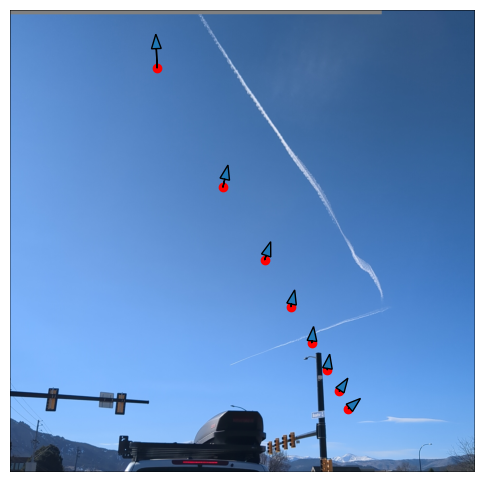

In [20]:
QUERY = (
    """SELECT *, ST_X(position) as longitude, ST_Y(position) as latitude
    FROM `contrails-301217.workshop_observerapp.adsb_clean_resampled` 
    WHERE timestamp BETWEEN DATETIME("2024-02-28 21:02:00") AND DATETIME_ADD("2024-02-28 21:02:00", INTERVAL 2 HOUR) 
    AND icao_address LIKE 'A336E3'
    ORDER BY timestamp"""
)
query_job = bq_client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
image_df = rows.to_dataframe()
image_df = image_df.rename(columns={'altitude_baro':'altitude_ft','timestamp':'time'})
fl = Flight(image_df)
fl['northward_wind'] = fl.intersect_met(met_pl['northward_wind'])
fl['eastward_wind'] = fl.intersect_met(met_pl['eastward_wind'])

# GPS to ENU coordinates
easting, northing, _, _ = utm.from_latlon(image_df['latitude'],image_df['longitude'],location_utm[2], location_utm[3])

# Tranform from world coordinates (east-north-up) to camera coordinates (right-down-forward)
T__cam__enu = np.linalg.inv(T__enu__cam)

# Camera matrix in projective coordinates
P = np.hstack((calibration['cam_matrix'], np.array([[0], [0], [0]])))

scale = 100.0

px = []
arrow_end = []
for i in range(len(easting)):
    plane__enu = np.array([[easting[i], northing[i], image_df['altitude_ft'][i], 1]]).T
    
    plane__cam = T__cam__enu @ plane__enu
    plane__cam /= plane__cam[-1]
    plane__undistorted_img = P @ plane__cam
    plane__undistorted_img /= plane__undistorted_img[-1]
    pt = plane__undistorted_img[0:2]
    
    #Only save trajectory points in FOV
    if np.all(pt > 0) and np.all(pt<ny):
        px.append(pt)

        arrow__enu = np.array([[
            easting[i]+scale*fl['eastward_wind'][i], 
            northing[i]+scale*fl['northward_wind'][i], 
            image_df['altitude_ft'][i], 
            1]]).T
        arrow__cam = T__cam__enu @ arrow__enu
        arrow__cam /= arrow__cam[-1]
        arrow__undistorted_img = P @ arrow__cam
        arrow__undistorted_img /= arrow__undistorted_img[-1]
        pt = arrow__undistorted_img[0:2]
        arrow_end.append(pt)
px = np.array(px)[:,:,0]
arrow_end = np.array(arrow_end)[:,:,0]

rot_px = rotate_pixels(px, -90, nx, ny)
rot_arrow = rotate_pixels(arrow_end, -90, nx, ny)

fig, ax = plt.subplots(1,figsize=(6,6))
ax.imshow(img_undistorted[...,::-1],aspect='auto')
ax.scatter(rot_px[:,0],rot_px[:,1], c='red')
#ax.scatter(rot_arrow[:,0], rot_arrow[:,1])
for i in range(len(rot_px)):
    ax.arrow(rot_px[i,0],rot_px[i,1],rot_arrow[i,0]-rot_px[i,0],rot_arrow[i,1]-rot_px[i,1], head_width=40)
ax.set_axis_off()

This looks like it could be a match!

There is a third plane that recently cross through the field of view. Let's check that one as well.

## Third Plane

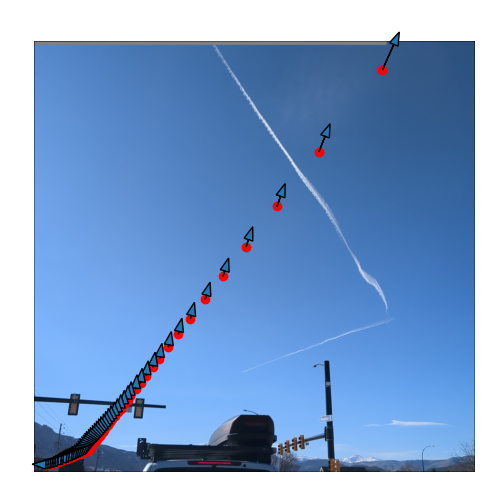

In [21]:
QUERY = (
    """SELECT *, ST_X(position) as longitude, ST_Y(position) as latitude
    FROM `contrails-301217.workshop_observerapp.adsb_clean_resampled` 
    WHERE timestamp BETWEEN DATETIME("2024-02-28 21:02:00") AND DATETIME_ADD("2024-02-28 21:02:00", INTERVAL 2 HOUR) 
    AND icao_address LIKE 'A2B416'
    ORDER BY timestamp"""
)
query_job = bq_client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
image_df = rows.to_dataframe()
image_df = image_df.rename(columns={'altitude_baro':'altitude_ft','timestamp':'time'})
fl = Flight(image_df)
fl['northward_wind'] = fl.intersect_met(met_pl['northward_wind'])
fl['eastward_wind'] = fl.intersect_met(met_pl['eastward_wind'])

# GPS to ENU coordinates
easting, northing, _, _ = utm.from_latlon(image_df['latitude'],image_df['longitude'],location_utm[2], location_utm[3])

# Tranform from world coordinates (east-north-up) to camera coordinates (right-down-forward)
T__cam__enu = np.linalg.inv(T__enu__cam)

# Camera matrix in projective coordinates
P = np.hstack((calibration['cam_matrix'], np.array([[0], [0], [0]])))

scale = 100.0

px = []
arrow_end = []
for i in range(len(easting)):
    plane__enu = np.array([[easting[i], northing[i], image_df['altitude_ft'][i], 1]]).T
    
    plane__cam = T__cam__enu @ plane__enu
    plane__cam /= plane__cam[-1]
    plane__undistorted_img = P @ plane__cam
    plane__undistorted_img /= plane__undistorted_img[-1]
    pt = plane__undistorted_img[0:2]
    
    #Only save trajectory points in FOV
    if np.all(pt > 0) and np.all(pt<ny):
        px.append(pt)

        arrow__enu = np.array([[
            easting[i]+scale*fl['eastward_wind'][i], 
            northing[i]+scale*fl['northward_wind'][i], 
            image_df['altitude_ft'][i], 
            1]]).T
        arrow__cam = T__cam__enu @ arrow__enu
        arrow__cam /= arrow__cam[-1]
        arrow__undistorted_img = P @ arrow__cam
        arrow__undistorted_img /= arrow__undistorted_img[-1]
        pt = arrow__undistorted_img[0:2]
        arrow_end.append(pt)
px = np.array(px)[:,:,0]
arrow_end = np.array(arrow_end)[:,:,0]

rot_px = rotate_pixels(px, -90, nx, ny)
rot_arrow = rotate_pixels(arrow_end, -90, nx, ny)

fig, ax = plt.subplots(1,figsize=(6,6))
ax.imshow(img_undistorted[...,::-1],aspect='auto')
ax.scatter(rot_px[:,0],rot_px[:,1], c='red')
#ax.scatter(rot_arrow[:,0], rot_arrow[:,1])
for i in range(len(rot_px)):
    ax.arrow(rot_px[i,0],rot_px[i,1],rot_arrow[i,0]-rot_px[i,0],rot_arrow[i,1]-rot_px[i,1], head_width=40)
ax.set_axis_off()

This doesn't appear to match any contrails in this image :(